# Experiment 6: GMM Clustering after Autoencoder Dimensionality Reduction

## Imports and Configuration

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.autoencoder import Autoencoder
from src.models.gmm import GMM, Covariance
from src.utils.metrics import *
from src.utils.utils import *

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data Loading and Preprocessing

In [12]:
X_scaled, y_true = load_scale_data(data_path='./data/breast_cancer.csv')

print(f"Dataset shape: {X_scaled.shape}")
print(f"Labels shape: {y_true.shape}")

Dataset shape: (569, 30)
Labels shape: (569,)


## Comprehensive Grid Search: Dimensions & Covariance

In [13]:
bottleneck_dims = [2, 5, 10, 15, 20]
cov_types = [Covariance.FULL, Covariance.TIED, Covariance.DIAGONAL, Covariance.SPHERICAL]
ae_gmm_results = []

for b_dim in bottleneck_dims:
    # 1. Train/Load Autoencoder for this dimension
    ae = Autoencoder(input_dim=X_scaled.shape[1], encoding_dims=[64, 32], bottleneck_dim=b_dim)
    ae.fit(X_scaled, verbose=False)
    X_latent = ae.encode(X_scaled)
    
    for cov_t in cov_types:
        # 2. Fit GMM (k=2)
        gmm = GMM(k=2, covariance_type=cov_t, max_iter=100)
        gmm.fit(X_latent)
        y_pred = gmm.predict(X_latent)
        
        # 3. Collect Evaluation
        metrics = evaluate_clustering(X_latent, y_true, y_pred, gmm)
        metrics.update({'Dimensions': b_dim, 'Covariance': cov_t.value})
        ae_gmm_results.append(metrics)

results_df = pd.DataFrame(ae_gmm_results)
results_df

c:\Users\Youssef\OneDrive\Desktop\ML\labs\asgmt4\src\utils\metrics.py:34: RuntimeWarning: invalid value encountered in scalar divide
  s_scores[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0


,ARI,NMI,Purity,Silhouette,Log-Likelihood,BIC,AIC,Dimensions,Covariance
0,0.000000,0.000000,0.627417,NaN,6420.872711,-12771.962737,-12819.745422,2,full
1,0.000000,0.000000,0.627417,NaN,6420.872711,-12790.994378,-12825.745422,2,tied
2,0.000000,0.000000,0.627417,NaN,6420.872711,-12784.650498,-12823.745422,2,diagonal
3,0.000000,0.000000,0.627417,NaN,6420.872711,-12797.338259,-12827.745422,2,spherical
4,-0.017620,0.030042,0.627417,-0.064229,11741.216963,-23222.334828,-23400.433925,5,full
5,0.388045,0.391450,0.811951,0.591929,11301.470975,-22438.001058,-22550.941950,5,tied
6,-0.016529,0.028101,0.627417,-0.067312,11741.038667,-23348.855844,-23440.077333,5,diagonal
7,0.510800,0.460821,0.857645,0.619842,-662.577313,1407.625072,1351.154626,5,spherical
8,-0.005552,0.009376,0.627417,0.543051,10952.447198,-21073.846059,-21642.894396,10,full
9,0.048242,0.038669,0.627417,0.095068,10799.539555,-21116.944197,-21447.079110,10,tied


## Analysis of Optimal Covariance Type

            count          mean           std           min           25%  \
Covariance                                                                  
diagonal      5.0 -19433.959984   4850.832335 -24779.141803 -23348.855844   
full          5.0 -20644.890410   4784.439699 -25413.929740 -23222.334828   
spherical     5.0   6407.748170  12215.573460 -12797.338259   1407.625072   
tied          5.0 -16900.331666   4662.624011 -22438.001058 -21116.944197   

                     50%           75%           max  
Covariance                                            
diagonal   -19269.528816 -16987.622958 -12784.650498  
full       -21073.846059 -20742.378684 -12771.962737  
spherical   12207.363244  15496.801286  15724.289509  
tied       -15765.356642 -12790.994378 -12390.362054  


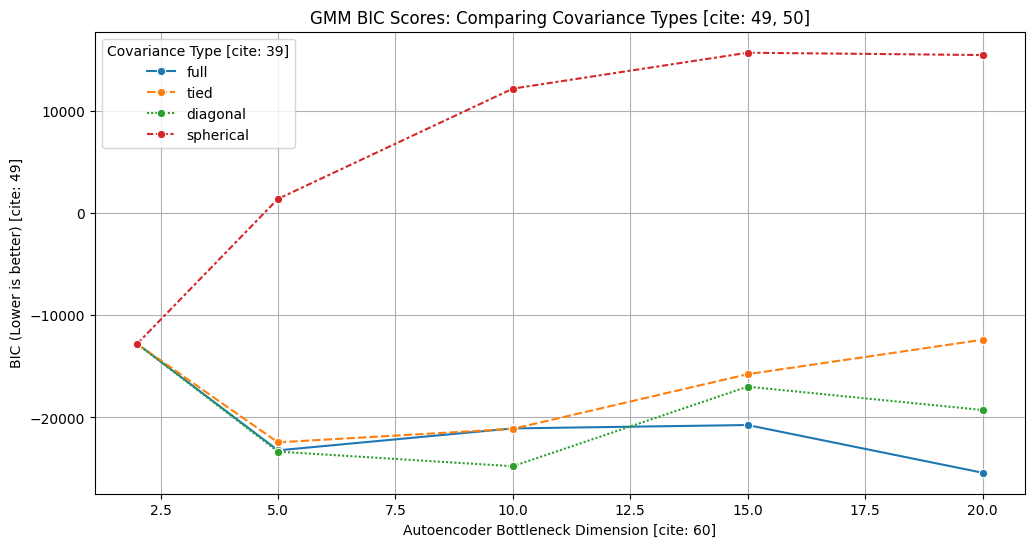

In [15]:
# Check if any covariance types resulted in NaN/Inf values
print(results_df.groupby('Covariance')['BIC'].describe())

plt.figure(figsize=(12, 6))
# Filter out non-finite values
clean_df = results_df[np.isfinite(results_df['BIC'])]

sns.lineplot(data=clean_df, x='Dimensions', y='BIC', hue='Covariance', marker='o', style='Covariance')
plt.title("GMM BIC Scores: Comparing Covariance Types [cite: 49, 50]")
plt.ylabel("BIC (Lower is better) [cite: 49]")
plt.xlabel("Autoencoder Bottleneck Dimension [cite: 60]")
plt.grid(True, which="both", ls="-")
plt.legend(title="Covariance Type [cite: 39]")
plt.show()

## Visualizing Best Latent Clusters

Best Config: Dim=15, Cov=spherical


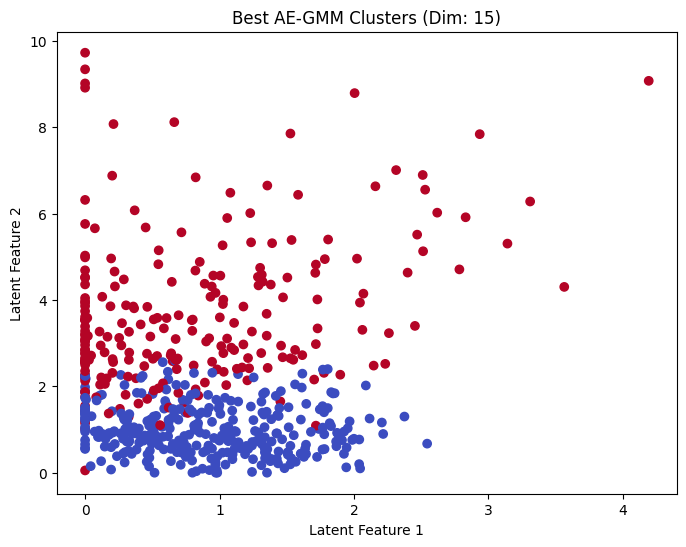

In [28]:
# Select best performing config (highest ARI)
best_config = results_df.loc[results_df['ARI'].idxmax()]
print(f"Best Config: Dim={best_config['Dimensions']}, Cov={best_config['Covariance']}")

# Re-run best for visualization
ae_best = Autoencoder(X_scaled.shape[1], [64, 32], best_config['Dimensions']).fit(X_scaled, verbose=False)
X_best_latent = ae_best.encode(X_scaled)
gmm_best = GMM(k=2, covariance_type=Covariance(best_config['Covariance']))
gmm_best.fit(X_best_latent)

plt.figure(figsize=(8, 6))
plt.scatter(X_best_latent[:, 0], X_best_latent[:, 1], c=gmm_best.predict(X_best_latent), cmap='coolwarm')
plt.title(f"Best AE-GMM Clusters (Dim: {best_config['Dimensions']})")
plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.show()

## Final Comparison Table

In [29]:
summary_comparison = results_df.sort_values(by='ARI', ascending=False).head(10)
print("Top 10 AE-GMM Configurations:")
display(summary_comparison)

Top 10 AE-GMM Configurations:


,ARI,NMI,Purity,Silhouette,Log-Likelihood,BIC,AIC,Dimensions,Covariance
15,0.677307,0.553601,0.912127,0.466862,-7757.470727,15724.289509,15580.941454,15,spherical
12,0.587908,0.467511,0.884007,0.336311,11230.785141,-20742.378684,-21919.570282,15,full
14,0.514990,0.407329,0.859402,0.345780,8687.299832,-16987.622958,-17252.599664,15,diagonal
11,0.514098,0.394824,0.859402,0.466654,-6030.726997,12207.363244,12107.453994,10,spherical
7,0.510800,0.460821,0.857645,0.619842,-662.577313,1407.625072,1351.154626,5,spherical
5,0.388045,0.391450,0.811951,0.591929,11301.470975,-22438.001058,-22550.941950,5,tied
10,0.261903,0.341524,0.757469,0.099023,12519.620450,-24779.141803,-24957.240900,10,diagonal
18,0.244372,0.297746,0.748682,0.129326,9891.691566,-19269.528816,-19621.383131,20,diagonal
16,0.243509,0.339005,0.748682,0.174401,14169.229310,-25413.929740,-27416.458621,20,full
13,0.127130,0.083486,0.695958,0.327008,8361.641294,-15765.356642,-16421.282587,15,tied
